In [118]:
import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
import lmfit

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

from carl.learning.calibration import HistogramCalibrator, IsotonicCalibrator, SigmoidCalibrator

from awkde import GaussianKDE


# Translation between s and r

In [48]:
def s(r):
    return 1./(1. + r)

def r(s):
    return (1.-s)/s

# Data

In [3]:
# Benchmark
theta1 = 708
theta = 9

# Data
data_dir = '../data'
figure_dir = '../figures/calibration'

X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_' + str(theta) + '.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_' + str(theta) + '.npy')
r_train = np.load(data_dir + '/unweighted_events/r_train_point_by_point_' + str(theta) + '.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')[::10]
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')[:,::10]

X_test = np.load(data_dir + '/unweighted_events/X_test.npy')
r_test = np.load(data_dir + '/unweighted_events/r_test.npy')[theta]
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)
X_test_transformed = scaler.transform(X_test)

# keras requires training data with the same output as the NN
log_r_gradients_train = np.zeros((r_train.shape[0], 43))
log_r_gradients_train[:,0] = np.log(r_train)
y_gradients_train = np.zeros((r_train.shape[0], 43))
y_gradients_train[:,0] = y_train

# Finally, s points for the calibration curves
s_eval = np.linspace(0., 1., 200).reshape((-1,1))

In [4]:
# Covariance matrix over a subset of the X for the grad-adaptive approach
X_indices = [0,1,2,3,39,40,41] # j1 momentum + delta eta, delta phi, mjj
X_small = X_train_transformed[::,X_indices]
cov_X = np.cov(X_small, rowvar=False)

# Train regression

In [5]:
n_features = 42

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,0], y_pred[:,0])

def make_regressor(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    s_hat_layer = Lambda(lambda x : 1. / 1. + x)(log_r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([log_r_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [16]:
# Train PbP regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                     epochs=20, verbose=1, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, log_r_gradients_train)

Train on 800000 samples, validate on 200000 samples
Epoch 1/20
800000/800000 [==============================] - 41s 51us/step - loss: 0.0467 - val_loss: 0.0423
Epoch 2/20
800000/800000 [==============================] - 41s 51us/step - loss: 0.0158 - val_loss: 0.0306
Epoch 3/20
800000/800000 [==============================] - 42s 52us/step - loss: 0.0124 - val_loss: 0.0271
Epoch 4/20
800000/800000 [==============================] - 43s 54us/step - loss: 0.0109 - val_loss: 0.0217
Epoch 5/20
800000/800000 [==============================] - 42s 53us/step - loss: 0.0100 - val_loss: 0.0276
Epoch 6/20
800000/800000 [==============================] - 45s 57us/step - loss: 0.0090 - val_loss: 0.0206
Epoch 7/20
800000/800000 [==============================] - 43s 54us/step - loss: 0.0084 - val_loss: 0.0218
Epoch 8/20
800000/800000 [==============================] - 44s 54us/step - loss: 0.0080 - val_loss: 0.0193
Epoch 9/20
800000/800000 [==============================] - 46s 57us/step - loss: 0.

In [17]:
# Evaluate on calibration sample
calibration_predictions = regr.predict(X_calibration_transformed)
log_r_hat_regr_calibration = calibration_predictions[:,0]
s_hat_regr_calibration = s(np.exp(log_r_hat_regr_calibration))
gradients_regr_calibration = calibration_predictions[:,1:]

s_hat_regr_calibration_carlinput = np.hstack((s_hat_regr_calibration,s_hat_regr_calibration))
y_regr_calibration_carlinput = np.hstack((np.zeros_like(s_hat_regr_calibration), np.ones_like(s_hat_regr_calibration)))
w_regr_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
r_hat_regr_test = np.exp(regr.predict(X_test_transformed)[:,0])
s_hat_regr_test = s(r_hat_regr_test)

48238/48238 [==============================] - 1s 17us/step


In [19]:
#Calculate KDE bandwidths

# Don't do this, will make N_x^2 * N_components large matrix in memory
#grad_cov_grad = np.diag( gradients_regr_calibration[:,X_indices].dot(
#    cov_X.dot(gradients_regr_calibration[:,X_indices].T)))

# Alternative:
grad_cov = cov_X.dot(gradients_regr_calibration[:,X_indices].T)
print(grad_cov.shape) # Should be small, large
grad_cov_grad = np.sum(grad_cov[:,:] * gradients_regr_calibration[:,X_indices].T, axis=0)

# Old code:
#mean_bw_nom = 1.5*1.5/11.4 * 1.5/2.37 * 1.5/1.8
#mean_bw_den = 1.1*1.1/5.85 * 1.09/1.27 * 1.09 / 1.2
#bandwidths = np.sqrt(grad_cov_grad)
#bandwidths = np.clip(bandwidths, np.mean(bandwidths) / 100., np.mean(bandwidths) * 100.)
#bandwidths_nom = mean_bw_nom / np.mean(bandwidths) * bandwidths
#bandwidths_nom = np.clip(bandwidths_nom, 0.1,10.)
#bandwidths_den = mean_bw_den / np.mean(bandwidths) * bandwidths
#bandwidths_den = np.clip(bandwidths_den, 0.1,10.)

# Get bandwidths and clip
bandwidths_regr = np.sqrt(np.copy(grad_cov_grad))
bandwidths_regr = np.clip(bandwidths_regr, 0., np.mean(bandwidths_regr) * 10.)
bandwidths_regr /= np.mean(bandwidths_regr)
bandwidths_regr = np.clip(bandwidths_regr, 0.1,10.)
print(np.min(bandwidths_regr), np.mean(bandwidths_regr), np.max(bandwidths_regr))

(7, 99955)
0.1 0.9982026294761324 10.0


# Train carl

In [11]:
def loss_function_carl(y_true, y_pred):
    return losses.binary_crossentropy(y_true[:,0], y_pred[:,0])

def make_classifier(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
        
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    r_hat_layer = Lambda(lambda x: K.exp(x))(log_r_hat_layer)
    s_hat_layer = Lambda(lambda x: 1./(1. + x))(r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([s_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_carl,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [12]:
# Train score regression
clf = KerasRegressor(lambda: make_classifier(n_hidden_layers=2),
                     epochs=20, verbose=1, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

clf.fit(X_train_transformed, y_gradients_train)

Train on 800000 samples, validate on 200000 samples
Epoch 1/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.6297 - val_loss: 0.9294
Epoch 2/20
800000/800000 [==============================] - 47s 58us/step - loss: 0.6257 - val_loss: 0.8793
Epoch 3/20
800000/800000 [==============================] - 45s 57us/step - loss: 0.6248 - val_loss: 0.9930
Epoch 4/20
800000/800000 [==============================] - 47s 59us/step - loss: 0.6245 - val_loss: 0.9606
Epoch 5/20
800000/800000 [==============================] - 48s 60us/step - loss: 0.6242 - val_loss: 0.9044
Epoch 00005: early stopping


In [13]:
# Evaluate on calibration sample
calibration_predictions = clf.predict(X_calibration_transformed)
s_hat_carl_calibration = calibration_predictions[:,0]
gradients_carl_calibration = calibration_predictions[:,1:]

s_hat_carl_calibration_carlinput = np.hstack((s_hat_carl_calibration,s_hat_carl_calibration))
y_carl_calibration_carlinput = np.hstack((np.zeros_like(s_hat_carl_calibration),
                                          np.ones_like(s_hat_carl_calibration)))
w_carl_calibration_carlinput = np.hstack((weights_calibration[theta,::], weights_calibration[theta1,::]))

# Evaluate on test sample
s_hat_carl_test = clf.predict(X_test_transformed)[:,0]
r_hat_carl_test = r(s_hat_carl_test)

48238/48238 [==============================] - 1s 15us/step


In [20]:
# Don't do this, will make N_x^2 * N_components large matrix in memory
#grad_cov_grad = np.diag( gradients_regr_calibration[:,X_indices].dot(
#    cov_X.dot(gradients_regr_calibration[:,X_indices].T)))

# Alternative:
grad_cov = cov_X.dot(gradients_carl_calibration[:,X_indices].T)
print(grad_cov.shape) # Should be small, large
grad_cov_grad = np.sum(grad_cov[:,:] * gradients_carl_calibration[:,X_indices].T, axis=0)

# Old code:
#mean_bw_nom = 1.5*1.5/11.4 * 1.5/2.37 * 1.5/1.8
#mean_bw_den = 1.1*1.1/5.85 * 1.09/1.27 * 1.09 / 1.2
#bandwidths = np.sqrt(grad_cov_grad)
#bandwidths = np.clip(bandwidths, np.mean(bandwidths) / 100., np.mean(bandwidths) * 100.)
#bandwidths_nom = mean_bw_nom / np.mean(bandwidths) * bandwidths
#bandwidths_nom = np.clip(bandwidths_nom, 0.1,10.)
#bandwidths_den = mean_bw_den / np.mean(bandwidths) * bandwidths
#bandwidths_den = np.clip(bandwidths_den, 0.1,10.)

# Get bandwidths and clip
bandwidths_carl = np.sqrt(np.copy(grad_cov_grad))
bandwidths_carl = np.clip(bandwidths_carl, 0., np.mean(bandwidths_carl) * 10.)
bandwidths_carl /= np.mean(bandwidths_carl)
bandwidths_carl = np.clip(bandwidths_carl, 0.1,10.)
print(np.min(bandwidths_carl), np.mean(bandwidths_carl), np.max(bandwidths_carl))

(7, 99955)
0.1 1.0017120838226363 7.357723585568792


In [21]:
print(bandwidths_regr)
print(bandwidths_carl)

[0.28073004 0.55762037 0.65474012 ... 1.25885643 0.15607552 0.2522768 ]
[0.65857101 1.00473487 0.18892749 ... 1.25377431 0.1        0.12768557]


# Calibration method list

In [157]:
# list of tuples (label1, label2, tool, mode, settings)
# label is used in tables and plots
# tool can be 'carl' for the built-in calibration methods and 'kde'
#   for the adaptive KDE techniques (including the gradient one)
# mode can be 'histogram', 'isotonic', ... for tool='carl', and
#   'fixed', 'adaptive', 'grad' for tool='kde'
# settings is a dict with settings passed to the Calibrator or GaussianKDE objects

calibrations = [] 

def _add(*args):
    calibrations.append(args)
    
# Uncalibrated
_add('No calibration', '', 'none', None, None)

# Histogram calibration
_add('Histogram', '25 equidistant bins', 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False})
_add('', '50 equidistant bins', 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False})
_add('', '100 equidistant bins', 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False})
_add('', '200 equidistant bins', 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False})

_add('', '25 equidistant bins, linear interpolation', 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '50 equidistant bins, linear interpolation', 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '100 equidistant bins, linear interpolation', 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})
_add('', '200 equidistant bins, linear interpolation', 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'linear'})

_add('', '25 equidistant bins, spline interpolation', 'carl', 'histo',
     {'bins':25, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '50 equidistant bins, spline interpolation', 'carl', 'histo',
     {'bins':50, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '100 equidistant bins, spline interpolation', 'carl', 'histo',
     {'bins':100, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})
_add('', '200 equidistant bins, spline interpolation', 'carl', 'histo',
     {'bins':200, 'independent_binning':False, 'variable_width':False, 'interpolation':'quadratic'})

_add('', '25 variable bins', 'carl', 'histo',
     {'bins':25, 'independent_binning':True, 'variable_width':True})
_add('', '50 variable bins', 'carl', 'histo',
     {'bins':50, 'independent_binning':True, 'variable_width':True})
_add('', '100 variable bins', 'carl', 'histo',
     {'bins':100, 'independent_binning':True, 'variable_width':True})
_add('', '200 variable bins', 'carl', 'histo',
     {'bins':200, 'independent_binning':True, 'variable_width':True})

# Isotonic
_add('Isotonic', 'no interpolation', 'carl', 'isotonic', {'interpolation':False})
_add('', 'linear interpolation', 'carl', 'isotonic', {'interpolation':True})

# Sigmoid
_add('Sigmoid', '', 'carl', 'sigmoid', {})

# fixed KDE
_add('KDE', 'fixed bandwidth', 'kde', 'fixed', {})

# adaptive KDE
_add('', r'adaptive ($\alpha=0.25$)', 'kde', 'adaptive', {'alpha':0.25})
_add('', r'adaptive ($\alpha=0.5$)', 'kde', 'adaptive', {'alpha':0.5})
_add('', r'adaptive ($\alpha=0.75$)', 'kde', 'adaptive', {'alpha':0.75})
_add('', r'adaptive ($\alpha=1$)', 'kde', 'adaptive', {'alpha':1.})

# grad-adaptive KDE
_add('KDE', r'grad-adaptive ($\beta=0.2$)', 'kde', 'grad', {'factor':0.2})
_add('', r'grad-adaptive ($\beta=0.5$)', 'kde', 'grad', {'factor':0.5})
_add('', r'grad-adaptive ($\beta=1$)', 'kde', 'grad', {'factor':1.})
_add('', r'grad-adaptive ($\beta=2$)', 'kde', 'grad', {'factor':2.})
_add('', r'grad-adaptive ($\beta_{\text{num}} = 1.66$, $\beta_{\text{den}} = 1.13$)',
     'kde', 'grad', {'factor':'auto'})

# Analytic fits
_add('Analytic', r'Equation~\eqref{eq:analytic_calibration_function} fit to histogram', 'fit', '',
     {'bins':100, 'independent_binning':False, 'variable_width':False})

plot_labels = []
last_label1 = ''
for cal in calibrations:
    label2_string = '' if cal[1] == '' else ', ' + cal[1]
    if cal[0] == '':
        plot_labels.append(last_label1 + label2_string)
    else:
        plot_labels.append(cal[0] + label2_string)
        last_label1 = cal[0]


# Calibration routines

In [54]:
def calibrate_none(use_regression=False):
    
    # Optimal calibration curve
    r_hat_eval = r(s_eval)
    
    # Test sample
    if use_regression:
        r_hat_test = r_hat_regr_test
    else:
        r_hat_test = r_hat_carl_test
    
    # Return results
    return(r_hat_eval, r_hat_test)

In [55]:
def calibrate_carl(mode, settings, use_regression=False):
    
    # Fit carl Calibrator object
    if mode in ['histogram', 'histo']:
        calibrator = HistogramCalibrator(**settings)
    elif mode == 'isotonic':
        calibrator = IsotonicCalibrator(**settings)
    elif mode == 'sigmoid':
        calibrator = SigmoidCalibrator(**settings)
    else:
        raise ValueError('Unknown mode "' + mode + '"')
    
    if use_regression:
        calibrator.fit(s_hat_regr_calibration_carlinput, y_regr_calibration_carlinput,
                       sample_weight=w_regr_calibration_carlinput)
    else:
        calibrator.fit(s_hat_carl_calibration_carlinput, y_carl_calibration_carlinput,
                       sample_weight=w_carl_calibration_carlinput)

    # Calibration curve
    s_hat_calibrated_eval = calibrator.predict(s_eval.reshape((-1,)))
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    if use_regression:
        s_hat_calibrated_test = calibrator.predict(s_hat_regr_test.reshape((-1,)))
    else:
        s_hat_calibrated_test = calibrator.predict(s_hat_carl_test.reshape((-1,)))
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

In [136]:
def calibrate_fit(mode, settings, use_regression=False):
    
    # Calibration function
    def calibration_function(x, alpha):
        return (1. - alpha) * x / (alpha * (1. - x) + (1. - alpha) * x)
    
    # First, fit histogram
    calibrator = HistogramCalibrator(**settings)
    
    if use_regression:
        calibrator.fit(s_hat_regr_calibration_carlinput, y_regr_calibration_carlinput,
                       sample_weight=w_regr_calibration_carlinput)
        s_hat_calibrated_calibration = calibrator.predict(s_hat_regr_calibration)
    else:
        calibrator.fit(s_hat_carl_calibration_carlinput, y_carl_calibration_carlinput,
                       sample_weight=w_carl_calibration_carlinput)
        s_hat_calibrated_calibration = calibrator.predict(s_hat_carl_calibration)
    
    ##Fit calibration function to (s raw, s calibrated)
    #popt, pcov = curve_fit(calibration_function,
    #                       s_hat_regr_calibration if use_regression else s_hat_carl_calibration,
    #                       s_hat_calibrated_calibration)
    #best_alpha = popt[0]
    #print('alpha =', best_alpha)
    
    # Fit calibration function to (s raw, s calibrated)
    model = lmfit.Model(calibration_function)
    params = model.make_params()
    params['alpha'].set(value=0.5,min=0.05,max=0.95,brute_step=0.001)
    result = model.fit(s_hat_calibrated_calibration,
                       params,
                       x=s_hat_regr_calibration if use_regression else s_hat_carl_calibration,
                       method='brute',
                       fit_kws={})
    #print(result.fit_report())
    best_alpha = result.best_values['alpha']

    # Calibration curve
    s_hat_calibrated_eval = calibration_function(s_eval.reshape((-1,)), best_alpha)
    r_hat_calibrated_eval = r(s_hat_calibrated_eval)
    
    # Test sample
    if use_regression:
        s_hat_calibrated_test = calibration_function(s_hat_regr_test.reshape((-1,)), best_alpha)
    else:
        s_hat_calibrated_test = calibration_function(s_hat_carl_test.reshape((-1,)), best_alpha)
    r_hat_calibrated_test = r(s_hat_calibrated_test)
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)


In [57]:
def calibrate_kde(mode, settings, use_regression=False):
    
    # Settings
    settings_ = copy.deepcopy(settings)
    bandwidth_ = None
    
    if mode == 'fixed':
        settings_ = {'alpha':None}
        
    elif mode == 'adaptive':
        pass
    
    elif mode == 'grad':
        factor = settings_.pop('factor', 1.)
        if factor=='auto':
            bandwidth_num = 1.66 * (bandwidths_regr if use_regression else bandwidths_carl)
            bandwidth_den = 1.13 * (bandwidths_regr if use_regression else bandwidths_carl)
        else:
            bandwidth_num = factor * (bandwidths_regr if use_regression else bandwidths_carl)
            bandwidth_den = factor * (bandwidths_regr if use_regression else bandwidths_carl)
        
    else:
        raise ValueError(mode)
    
    pdf_nom = GaussianKDE(**settings_)
    pdf_den = GaussianKDE(**settings_)

    # Fit
    if use_regression:
        pdf_nom.fit(s_hat_regr_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta,::],
                    bandwidth=bandwidth_num)
        pdf_den.fit(s_hat_regr_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta1,::],
                    bandwidth=bandwidth_den)
    else:
        pdf_nom.fit(s_hat_carl_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta,::],
                    bandwidth=bandwidth_num)
        pdf_den.fit(s_hat_carl_calibration.reshape((-1,1)),
                    weights=weights_calibration[theta1,::],
                    bandwidth=bandwidth_den)
        
    # Extract bandwidths (for debugging purposes)
    if mode in ['adaptive', 'grad']:
        actual_bandwidths_nom = 1. / pdf_nom._inv_loc_bw
        actual_bandwidths_den = 1. / pdf_den._inv_loc_bw
    else:
        actual_bandwidths_nom = actual_bandwidths_den = np.ones_like(s_hat_carl_calibration)
    
    print('Bandwidth means:', np.mean(actual_bandwidths_nom), np.mean(actual_bandwidths_den))
    
    # Calibration curve
    p_hat_nom_eval = pdf_nom.predict(s_eval)
    p_hat_den_eval = pdf_den.predict(s_eval)
    r_hat_calibrated_eval = p_hat_nom_eval / p_hat_den_eval
    r_hat_calibrated_eval[p_hat_den_eval<=0.] = 1.
    
    # Test sample
    if use_regression:
        p_hat_nom_test = pdf_nom.predict(s_hat_regr_test.reshape((-1,1)))
        p_hat_den_test = pdf_den.predict(s_hat_regr_test.reshape((-1,1)))
        r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
        r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
    else:
        p_hat_nom_test = pdf_nom.predict(s_hat_carl_test.reshape((-1,1)))
        p_hat_den_test = pdf_den.predict(s_hat_carl_test.reshape((-1,1)))
        r_hat_calibrated_test = p_hat_nom_test / p_hat_den_test
        r_hat_calibrated_test[p_hat_den_test<=0.] = 1.
        
    # Sanitize output
    r_hat_calibrated_eval[np.invert(np.isfinite(r_hat_calibrated_eval))] = 1.
    r_hat_calibrated_test[np.invert(np.isfinite(r_hat_calibrated_test))] = 1.
    r_hat_calibrated_eval = np.clip(r_hat_calibrated_eval, np.exp(-10.), np.exp(10.))
    r_hat_calibrated_test = np.clip(r_hat_calibrated_test, np.exp(-10.), np.exp(10.))
    
    # Return results
    return(r_hat_calibrated_eval, r_hat_calibrated_test)

# Main loop

In [63]:
#r_hat_regr_calibrated_eval_list = []
#r_hat_carl_calibrated_eval_list = []
#r_hat_regr_calibrated_test_list = []
#r_hat_carl_calibrated_test_list = []
#mse_logr_regr_list = []
#mse_logr_carl_list = []

for i, (label1, label2, tool, mode, settings) in enumerate(calibrations):
    
    # Do calibration
    time_start = time.clock()
    
    if tool == 'none':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_none(True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_none(False)
        
    elif tool == 'carl':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_carl(mode, settings, True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_carl(mode, settings, False)
        
    elif tool == 'kde':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_kde(mode, settings, True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_kde(mode, settings, False)
        
    elif tool == 'fit':
        r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_fit(mode, settings, True)
        r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_fit(mode, settings, False)
        
    calibration_time = time.clock() - time_start
        
    # Store results for plots
    r_hat_regr_calibrated_eval_list.append(r_hat_regr_calibrated_eval)
    r_hat_carl_calibrated_eval_list.append(r_hat_carl_calibrated_eval)
    r_hat_regr_calibrated_test_list.append(r_hat_regr_calibrated_test)
    r_hat_carl_calibrated_test_list.append(r_hat_carl_calibrated_test)
    
    # Metrics
    mse_logr_regr = mean_squared_error(np.log(r_test), np.log(r_hat_regr_calibrated_test))
    mse_logr_carl = mean_squared_error(np.log(r_test), np.log(r_hat_carl_calibrated_test))
    mse_logr_regr_list.append(mse_logr_regr)
    mse_logr_carl_list.append(mse_logr_carl)
    
    print(i, label1, label2, ': MSEs =', mse_logr_carl, ',', mse_logr_regr, 'in', calibration_time, 's')

0 Analytic  : MSEs = 1.8397666150766867 , 1.4161802693271555 in 0.11025400000016816 s


In [159]:
if True:

    for i, (label1, label2, tool, mode, settings) in enumerate(calibrations):

        if i not in [13,14,15,16]:
            continue

        # Do calibration
        time_start = time.clock()

        if tool == 'none':
            r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_none(True)
            r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_none(False)

        elif tool == 'carl':
            r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_carl(mode, settings, True)
            r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_carl(mode, settings, False)

        elif tool == 'kde':
            r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_kde(mode, settings, True)
            r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_kde(mode, settings, False)

        elif tool == 'fit':
            r_hat_regr_calibrated_eval, r_hat_regr_calibrated_test = calibrate_fit(mode, settings, True)
            r_hat_carl_calibrated_eval, r_hat_carl_calibrated_test = calibrate_fit(mode, settings, False)

        calibration_time = time.clock() - time_start

        # Store results for plots
        r_hat_regr_calibrated_eval_list[i] = r_hat_regr_calibrated_eval
        r_hat_carl_calibrated_eval_list[i] = r_hat_carl_calibrated_eval
        r_hat_regr_calibrated_test_list[i] = r_hat_regr_calibrated_test
        r_hat_carl_calibrated_test_list[i] = r_hat_carl_calibrated_test

        # Metrics
        mse_logr_regr = mean_squared_error(np.log(r_test), np.log(r_hat_regr_calibrated_test))
        mse_logr_carl = mean_squared_error(np.log(r_test), np.log(r_hat_carl_calibrated_test))
        mse_logr_regr_list[i] = mse_logr_regr
        mse_logr_carl_list[i] = mse_logr_carl

        print(i, label1, label2, ': MSEs =', mse_logr_carl, ',', mse_logr_regr, 'in', calibration_time, 's')

13  25 variable bins : MSEs = 0.9452286530795735 , 1.5320814138358945 in 0.1416110000000117 s
14  50 variable bins : MSEs = 1.1861354582074777 , 1.6816770500633147 in 0.23435199999948964 s
15  100 variable bins : MSEs = 1.9081004044238945 , 1.7720548029432663 in 0.4312980000004245 s
16  200 variable bins : MSEs = 3.601036256989888 , 2.8245498934141775 in 0.8013010000004215 s


# Result table

In [64]:
class TablePrinter:
    
    def __init__(self, precisions, header=None):
        
        # Functions for metrics
        self.n_metrics = len(precisions)
        self.precisions = precisions
        
        # Total table and current block
        self.table = ''
        self.block_entries = []

        # Formatting options
        self.indent = '   '
        self.col_sep = ' & '
        self.end_row = r' \\'
        self.midrule = r'\midrule'
        self.end_line = u'\n'
        self.emphasis_begin = r'\mathbf{'
        self.emphasis_end = r'}'
        
        # Header
        self.table = ''
        if header is not None:
            self.table += self.indent + header + self.end_row + self.end_line
    
    
    def finalise_block(self):

        # Find best performance
        block_metrics = [line[2:] for line in self.block_entries]
        block_metrics = np.array(block_metrics)
        block_best = []
        for i in range(self.n_metrics):
            try:
                block_best.append(np.nanargmin(block_metrics[:,i]))
            except ValueError:
                block_best.append(-1)

        # Format entries
        text = ''
        for i, line in enumerate(self.block_entries):
            
            # Labels
            text += self.indent + line[0] + self.col_sep + line[1] + self.col_sep
            
            # Metrics
            for j in range(self.n_metrics):
                if np.isfinite(line[j + 2]):
                    text += self.format_number(line[j + 2], self.precisions[j], emphasize=(i == block_best[j]))
                if j == len(line) - 3:
                    text += self.end_row + self.end_line
                else:
                    text += self.col_sep

        # Add to document and reset for next block
        self.table += text
        self.block_entries = []
    
    
    def new_block(self):
        self.finalise_block()
        self.table += self.indent + self.midrule + self.end_line
    
    
    def format_number(self,
                      number,
                      precision=2,
                      trailing_zeros=True,
                      fix_minus_zero=True,
                      latex_math_mode=True,
                      emphasize=False):
        if precision == 0:
            temp =  str(int(round(number,precision)))
        elif trailing_zeros:
            temp =  ('{:.' + str(precision) + 'f}').format(round(number,precision))
        else:
            temp =  str(round(number,precision))
        if fix_minus_zero and len(temp) > 0:
            if temp[0] == '-' and float(temp) == 0.:
                temp = temp[1:]
        if latex_math_mode:
            if emphasize:
                temp = '$\mathbf{' + temp + '}$'
            else:
                temp = '$' + temp + '$'
        elif emphasize:
            temp = r'\emph{' + temp + r'}'
        return temp
    
    
    def add(self, col1, col2, values, folder='parameterized'):
        
        # Label columns
        line = [col1, col2] + values
        self.block_entries.append(line)
    
    
    def print(self):
        self.finalise_block()
        return self.table

In [139]:
table = TablePrinter(precisions=[4,3])

for i, ((label1, label2, _, _, _), mse_regr, mse_carl) in enumerate(zip(calibrations,
                                                        mse_logr_regr_list, mse_logr_carl_list)):
    
    if i > 0 and label1 != '':
        table.new_block()
        
    table.add(label1, label2, [mse_regr, mse_carl])
    
print(table.print())

   No calibration &  & $\mathbf{0.0026}$ & $\mathbf{0.260}$ \\
   \midrule
   Histogram & 25 equidistant bins & $0.0065$ & $0.034$ \\
    & 50 equidistant bins & $0.0038$ & $0.032$ \\
    & 100 equidistant bins & $0.0030$ & $0.032$ \\
    & 200 equidistant bins & $0.0028$ & $0.032$ \\
    & 25 equidistant bins, linear interpolation & $0.0052$ & $0.033$ \\
    & 50 equidistant bins, linear interpolation & $0.0034$ & $\mathbf{0.032}$ \\
    & 100 equidistant bins, linear interpolation & $0.0029$ & $0.032$ \\
    & 200 equidistant bins, linear interpolation & $\mathbf{0.0027}$ & $0.032$ \\
    & 25 equidistant bins, spline interpolation & $0.0051$ & $0.032$ \\
    & 50 equidistant bins, spline interpolation & $0.0034$ & $0.034$ \\
    & 100 equidistant bins, spline interpolation & $0.0029$ & $0.032$ \\
    & 200 equidistant bins, spline interpolation & $0.0060$ & $0.041$ \\
    & 25 variable bins & $1.5307$ & $0.945$ \\
    & 50 variable bins & $1.6809$ & $1.186$ \\
    & 100 variable bin

# Calibration curves

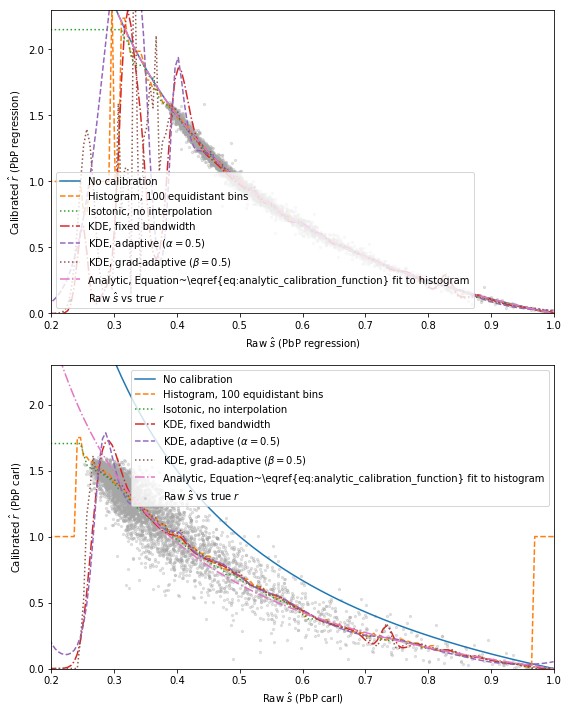

In [161]:
show_indices = [0,3,17,20,22,26,30]
linestyles=(['-'] + ['--',':','-.'] * 5)[:len(show_indices)]

plt.figure(figsize=(8.,10.))



plt.subplot(2,1,1)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, r_hat_regr_calibrated_eval_list[i], ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_regr_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP regression)')
plt.ylabel('Calibrated $\hat{r}$ (PbP regression)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.3)



plt.subplot(2,1,2)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, r_hat_carl_calibrated_eval_list[i], ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_carl_test[::10], r_test[::10], c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $r$')

plt.xlabel('Raw $\hat{s}$ (PbP carl)')
plt.ylabel('Calibrated $\hat{r}$ (PbP carl)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.,2.3)



plt.tight_layout()
plt.savefig(figure_dir + '/calibration_curves.pdf')

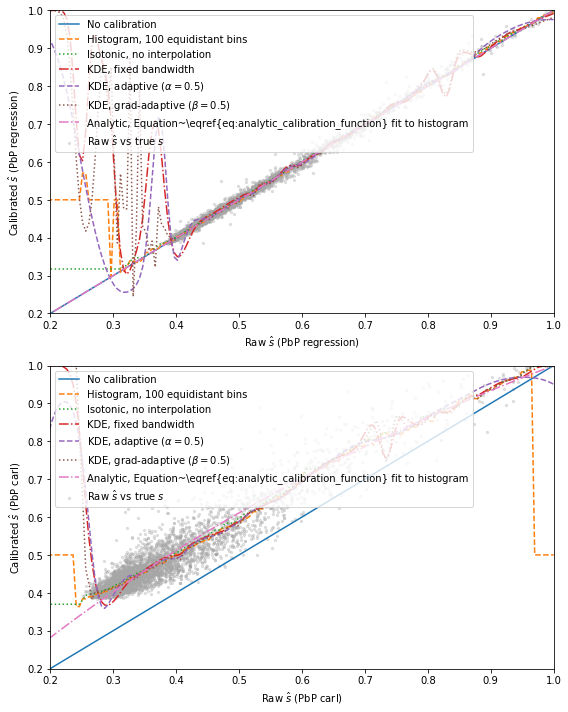

In [162]:
plt.figure(figsize=(8.,10.))



plt.subplot(2,1,1)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, s(r_hat_regr_calibrated_eval_list[i]), ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_regr_test[::10], s(r_test[::10]), c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $s$')

plt.xlabel('Raw $\hat{s}$ (PbP regression)')
plt.ylabel('Calibrated $\hat{s}$ (PbP regression)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.2,1.)



plt.subplot(2,1,2)

for i, ls in zip(show_indices, linestyles):
    plt.plot(s_eval, s(r_hat_carl_calibrated_eval_list[i]),ls=ls,
             label=plot_labels[i])

plt.scatter(s_hat_carl_test[::10], s(r_test[::10]), c='0.65', s=5., alpha=0.3, zorder=-10,
           label='Raw $\hat{s}$ vs true $s$')

plt.xlabel('Raw $\hat{s}$ (PbP carl)')
plt.ylabel('Calibrated $\hat{s}$ (PbP carl)')
plt.legend()
plt.xlim(0.2,1.)
plt.ylim(0.2,1.)



plt.tight_layout()
plt.savefig(figure_dir + '/calibration_s_curves.pdf')